# Set up the environment

In [1]:
import numpy as np
import pandas as pd
# Datareader has to be installed separately: > conda install pandas-datareader
# Module contains tools for collecting data from various remote sources
import pandas_datareader.data as web
import datetime as dt

import matplotlib.pylab as plt
import seaborn as sns

sns.set_context('notebook')
pd.set_option('float_format', '{:6.2f}'.format)

# Ignore warnings. This is a temporary bug that should disappear in future versions of the libraries used here.
import warnings
warnings.filterwarnings("ignore")


# Load data from Yahoo! Finance. Load only close prices of a few companies.

In [2]:
start = dt.datetime(2010, 1, 1)
end = dt.datetime(2015, 10, 1)

tickers = {'Tesla': 'TSLA', 'Ford': 'F', 'Oil ETF': 'UGA', 'Apple': 'AAPL'}
prices = []

print('===============================================================')
for company, tic in tickers.items():
    df = web.DataReader(tic, 'yahoo', start=start, end=end)[['Close']]
    df.rename(columns={'Close': company}, inplace=True)
    prices.append(df)

prices = pd.concat(prices, axis=1)

print(prices.head())
print('===============================================================')

            Tesla   Ford  Oil ETF  Apple
Date                                    
2010-01-04    nan  10.28    37.47   7.64
2010-01-05    nan  10.96    37.81   7.66
2010-01-06    nan  11.37    37.90   7.53
2010-01-07    nan  11.66    37.89   7.52
2010-01-08    nan  11.69    38.38   7.57


# Print primitive statistics

In [16]:
print(prices.describe())

        Tesla    Ford  Oil ETF   Apple
count 1325.00 1447.00  1447.00 1447.00
mean   108.69   13.87    48.71   73.49
std     92.75    2.38     9.98   27.70
min     15.80    8.92    28.53   27.44
25%     28.33   11.79    38.40   50.28
50%     37.40   14.11    50.36   71.80
75%    205.82   15.85    57.30   92.15
max    286.04   18.79    65.71  133.00


# Save the data to excel

In [22]:
prices.to_excel('stocks1.xlsx',
                sheet_name='Stock prices',
                na_rep='-999', float_format='%.2f')
print('Save file one...')

# Save data to separate sheets in the same Excel file.

In [23]:
writer = pd.ExcelWriter('stocks2.xlsx')
prices[['Ford', 'Tesla']].to_excel(writer, sheet_name='Auto')
prices[['Oil ETF']].to_excel(writer, sheet_name='Oil')
prices[['Apple']].to_excel(writer, sheet_name='Technology')
writer.save()
print('Save the second sheet...')

Save the second sheet...


# Save data to HDF file. This is convenient for further analysis in Pandas.

In [40]:
fname = 'stocks.hdf'
key = 'all_prices'
prices.to_hdf(fname, key=key)
# prices[['Oil ETF']].to_hdf(fname, key='Oil')
# prices[['Apple']].to_hdf(fname, key='Technology')
# prices.loc[:100, ['Ford', 'Tesla']].to_hdf(fname, key='Auto', format='t')
# prices.loc[:100:, ['Ford', 'Tesla']].to_hdf(fname, key='Auto', append=True)

loaded = pd.read_hdf(fname, key=key)
# auto = pd.read_hdf(fname, key='Auto')

print(loaded.head())
# print(prices.shape, auto.shape)

            Tesla   Ford  Oil ETF  Apple
Date                                    
2010-01-04    nan  10.28    37.47  30.57
2010-01-05    nan  10.96    37.81  30.63
2010-01-06    nan  11.37    37.90  30.14
2010-01-07    nan  11.66    37.89  30.08
2010-01-08    nan  11.69    38.38  30.28


# Save descriptive statistics as HTML file

In [27]:
df = prices.describe()
df.to_html('stocks_summary.html')

# Convert DataFrame to string with specified format.

In [28]:
df = prices.describe()
df = df.to_string(float_format=lambda x: '%.1f' % x, col_space=15,
                  justify='right')
print(df)

                          Tesla            Ford         Oil ETF           Apple
count                    1325.0          1447.0          1447.0          1447.0
mean                      108.7            13.9            48.7            73.5
std                        92.8             2.4            10.0            27.7
min                        15.8             8.9            28.5            27.4
25%                        28.3            11.8            38.4            50.3
50%                        37.4            14.1            50.4            71.8
75%                       205.8            15.8            57.3            92.1
max                       286.0            18.8            65.7           133.0


# Save DataFrame as LaTeX table.

In [29]:
df = prices.describe()
df.to_latex('stocks_summary.tex',
            float_format=lambda x: '%.1f' % x)

# Draw all prices on the same plot.

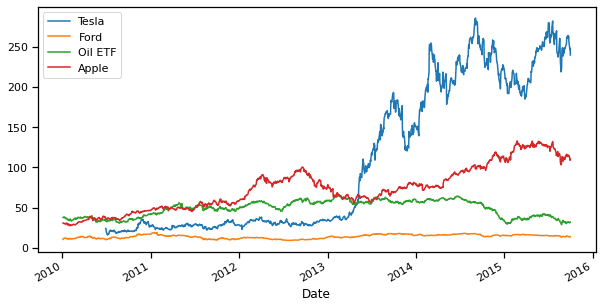

In [32]:
prices.plot(figsize=(10, 5))
plt.show()

# Compute Exponentially Weighted Moving Average.

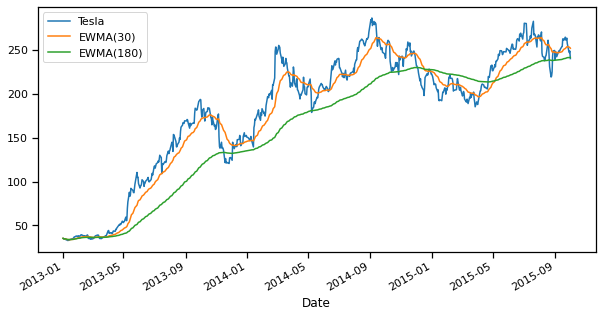

In [34]:
company = 'Tesla'
ewma = prices.loc['2013':, [company]]
for span in [30, 180]:
    ewma['EWMA(' + str(span) + ')'] = ewma[company].ewm(span=span).mean()
ewma.plot(figsize=(10, 5))
plt.show()

# Draw them on subplots.

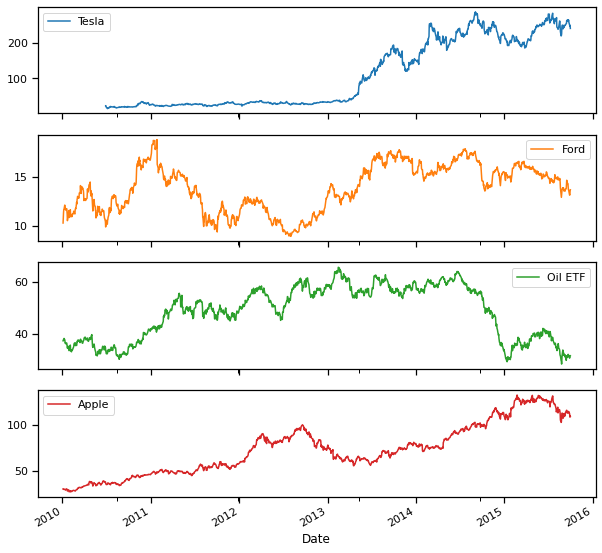

In [41]:
prices.plot(figsize=(10, 10), subplots=True)
plt.show()

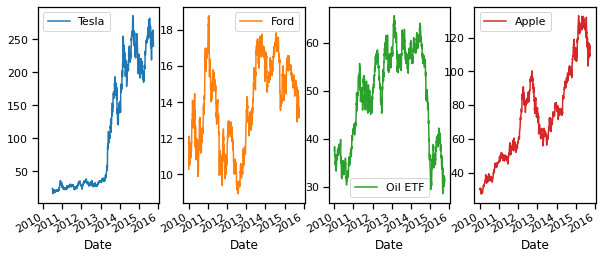

In [43]:
prices.plot(figsize=(10, 4), layout=(1, 4), subplots=True)
plt.show()

# Change styling temporarily and add the second Y-axis to the plot.

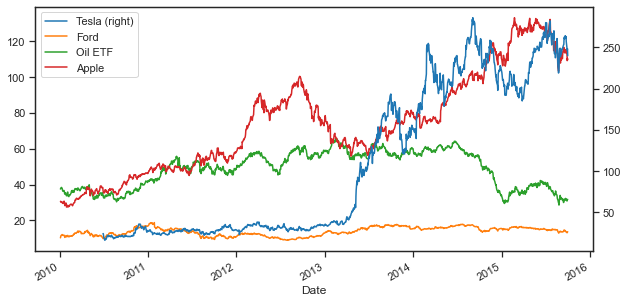

In [44]:
with sns.axes_style('white'):
    sns.set_style('ticks')
    prices.plot(figsize=(10, 5), secondary_y=['Tesla'])
    plt.show()

# Compute daily percentage log-returns.

In [45]:
returns = prices.apply(lambda x: 100 * np.log(x / x.shift())).dropna()
print(returns.describe())

        Tesla    Ford  Oil ETF   Apple
count 1324.00 1324.00  1324.00 1324.00
mean     0.17    0.02    -0.00    0.08
std      3.47    1.77     1.70    1.65
min    -21.48  -14.40    -7.56  -13.19
25%     -1.54   -0.91    -0.97   -0.77
50%      0.10    0.00     0.00    0.06
75%      1.91    0.99     1.01    1.03
max     21.83    9.41     6.39    8.50


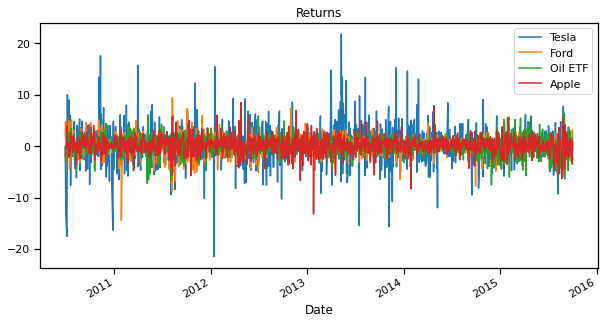

In [46]:
returns.plot(figsize=(10, 5), title='Returns')
plt.show()

# Plot distribution of daily returns.

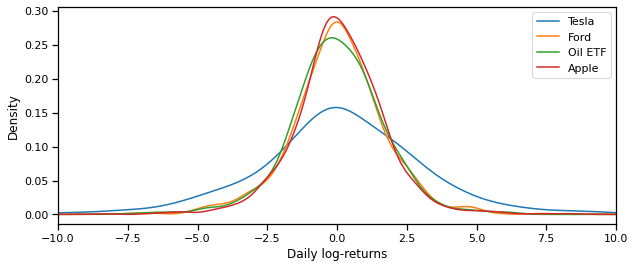

In [47]:
returns.plot(kind='kde', figsize=(10, 4))
plt.xlim([-10, 10])
plt.xlabel('Daily log-returns')
plt.show()

# Merge returns and prices.

In [48]:
data = pd.merge(prices, returns, how='outer',
                left_index=True, right_index=True,
                suffixes=[' (price)', ' (return)'])
print(data.shape)
print(data.head())

(1447, 8)
            Tesla (price)  Ford (price)  Oil ETF (price)  Apple (price)  \
Date                                                                      
2010-01-04            nan         10.28            37.47          30.57   
2010-01-05            nan         10.96            37.81          30.63   
2010-01-06            nan         11.37            37.90          30.14   
2010-01-07            nan         11.66            37.89          30.08   
2010-01-08            nan         11.69            38.38          30.28   

            Tesla (return)  Ford (return)  Oil ETF (return)  Apple (return)  
Date                                                                         
2010-01-04             nan            nan               nan             nan  
2010-01-05             nan            nan               nan             nan  
2010-01-06             nan            nan               nan             nan  
2010-01-07             nan            nan               nan             na

# Compute cumulative return for each stock.

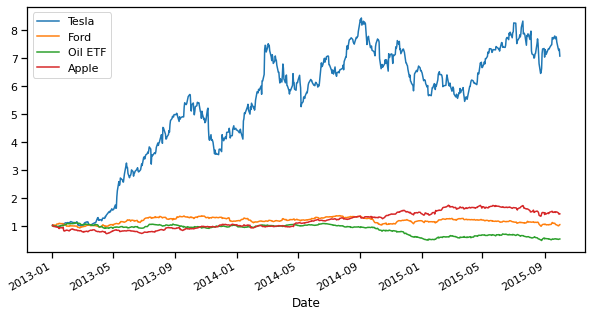

In [50]:
cumret = returns.loc['2013':].cumsum().apply(lambda x: np.exp(x / 100))
cumret.plot(figsize=(10, 5))
plt.show()

# Compute risk-adjusted cumulative return for each company.

        Tesla    Ford  Oil ETF   Apple
count 1324.00 1324.00  1324.00 1324.00
mean     0.05    0.01    -0.00    0.05
std      1.00    1.00     1.00    1.00
min     -6.20   -8.14    -4.46   -7.97
25%     -0.44   -0.52    -0.57   -0.47
50%      0.03    0.00     0.00    0.04
75%      0.55    0.56     0.59    0.62
max      6.30    5.32     3.77    5.14


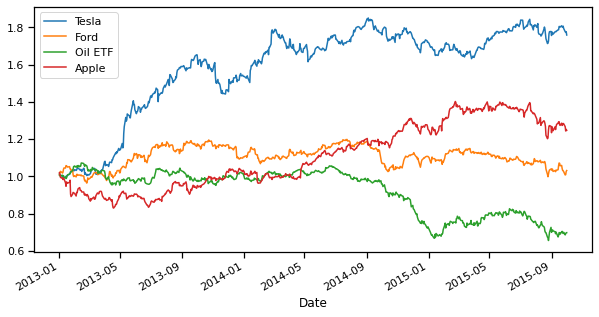

In [52]:
risk_adj = returns.apply(lambda x: x / x.std())
print(risk_adj.describe())

cumret = risk_adj.loc['2013':].cumsum().apply(lambda x: np.exp(x / 100))
cumret.plot(figsize=(10, 5))
plt.show()

# Compute average returns by month for each company.

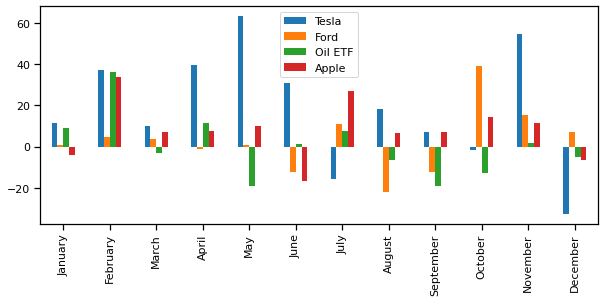

In [53]:
import calendar

ret_month = returns.copy()
ret_month = ret_month.groupby(lambda x: x.month).mean() * 100

plot = ret_month.plot(kind='bar', figsize=(10, 4))
ticks = [calendar.month_name[int(item.get_text())] for item in plot.get_xticklabels()]
plt.gca().set_xticklabels(ticks)
plt.show()

# Compute annual returns for each company.

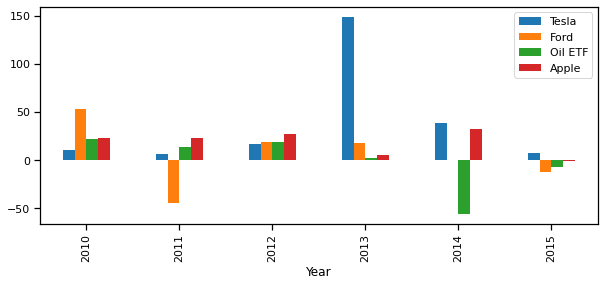

In [54]:
monthly = returns.resample('a').sum()
monthly['Year'] = monthly.index.year
monthly.reset_index(inplace=True, drop=True)
monthly.set_index('Year', inplace=True)

monthly.plot(kind='bar', figsize=(10, 4))
plt.show()

# Plot univariate densities, bivariate densities, scatters, and regression lines for all daily stock returns.

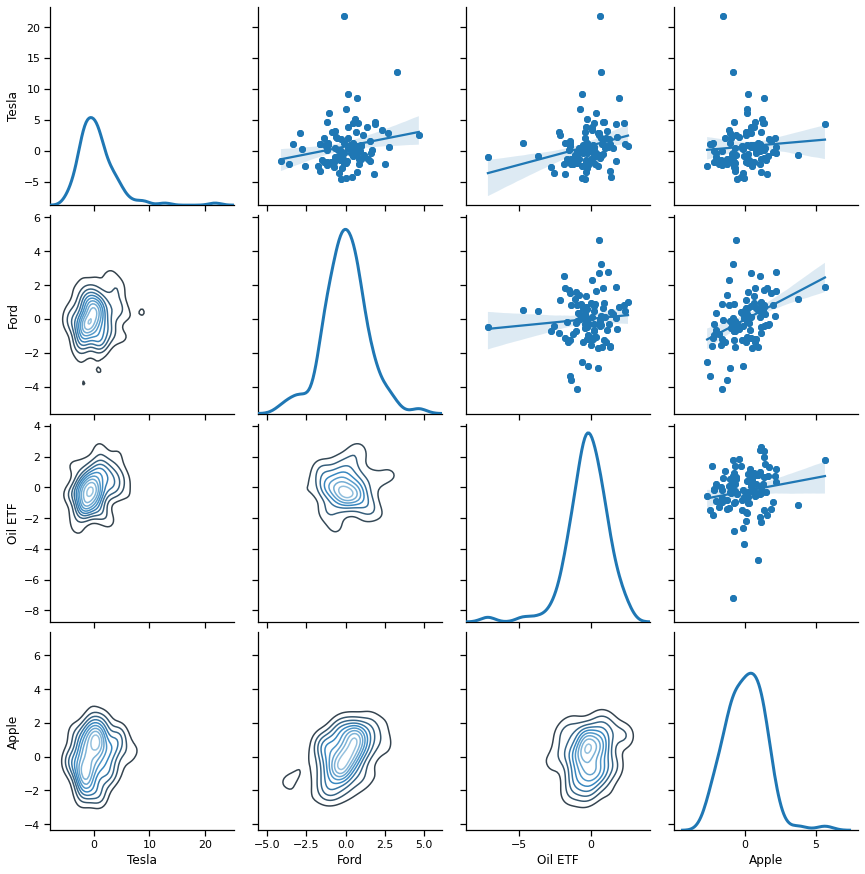

In [55]:
g = sns.PairGrid(returns.sample(100), size=3)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False)
g.map_upper(sns.regplot)
plt.show()

# Plot prices, returns, and cumulative returns on the same plot. Save the figure.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


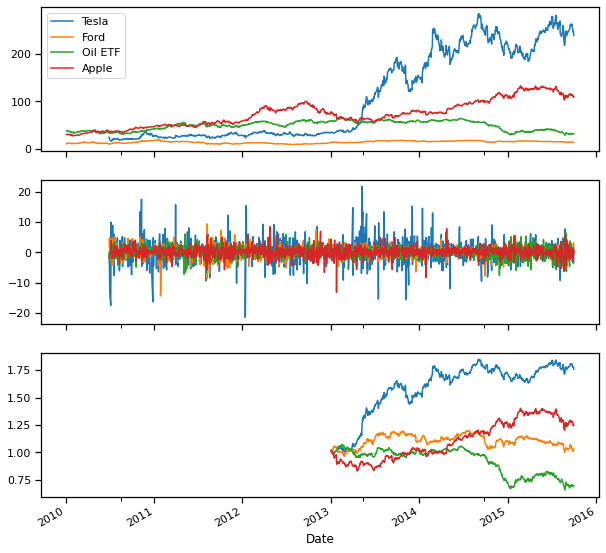

In [56]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), sharex=True)
prices.plot(ax=axes[0])
returns.plot(ax=axes[1])
cumret.plot(ax=axes[2])
axes[1].legend().set_visible(False)
axes[2].legend().set_visible(False)
plt.savefig('stocks.pdf')
plt.savefig('stocks.eps')
plt.show()

# Save plot iteratively for each modification. This will produce a pseudo-animation in LaTeX presentation.

In [59]:
company = 'Tesla'
ewma = prices.loc['2013':, [company]]

lines = []
for count, span in enumerate([30, 180]):
    name = 'EWMA(' + str(span) + ')'
    ewma[name] = ewma[company].ewm(span=span).mean()

ax = ewma.plot(figsize=(4, 3))
plt.legend(loc='lower right')
plt.tight_layout()
nlines = len(ax.lines)
for count, line in enumerate(ax.lines[::-1]):
    plt.savefig('tesla_' + str(nlines - 1 - count) + '.pdf')
    line.remove()
plt.close()
print('Data saved')

Data saved
